In [1]:
import cv2
import glob
import h5py
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import time
from tensorflow.python.framework import ops
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

%matplotlib inline

### Confusion Matrix Helper Function

In [2]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Process and Store Images to a database

In [ ]:
FILE_PATH_PARASITIZED = "datasets\\Archived\\Parasitized\\"
FILE_PATH_UNINFECTED = "datasets\\Archived\\Uninfected\\"

In [ ]:
parasitized = glob.glob(FILE_PATH_PARASITIZED + "*.png")
uninfected = glob.glob(FILE_PATH_UNINFECTED + "*.png")

In [ ]:
x_list = []
y_list = []

for image in parasitized:
    img = cv2.imread(image)
    res = cv2.resize(img, dsize=(32,32))
    x_list.append(res)
    y_list.append(1)
    
for image in uninfected:
    img = cv2.imread(image)
    res = cv2.resize(img, dsize=(32,32))
    x_list.append(res)
    y_list.append(0)
    
x = np.array(x_list)
y = np.array(y_list)

x = x/255.
y = y.reshape((y.shape[0],1))

print("x.shape: %s" % str(x.shape))
print("y.shape: %s" % str(y.shape))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

In [ ]:
hf_train = h5py.File("train_malaria.h5", "w")
hf_train.create_dataset("train_set_x", data=X_train)
hf_train.create_dataset("train_set_y", data=y_train)
hf_train.close()

hf_test = h5py.File("test_malaria.h5", "w")
hf_test.create_dataset("test_set_x", data=X_test)
hf_test.create_dataset("test_set_y", data=y_test)
hf_test.close()

# Loading Data

In [3]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_malaria.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_malaria.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig

In [4]:
X_train, Y_train, X_test, Y_test = load_dataset()

X_dev, X_test, Y_dev, Y_test = train_test_split(X_test, Y_test, test_size=0.5)

print(X_train.shape)
print(Y_train.shape)

print(X_dev.shape)
print(Y_dev.shape)

print(X_test.shape)
print(Y_test.shape)

(18463, 32, 32, 3)
(18463, 1)
(4547, 32, 32, 3)
(4547, 1)
(4548, 32, 32, 3)
(4548, 1)


# Creating the Network

### Model 1

In [5]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=8, kernel_size=(5,5), strides=1, padding="same", activation=tf.nn.relu, input_shape=(32,32,3)),
    tf.keras.layers.MaxPool2D(pool_size=(8,8), strides=8, padding="same"),
    
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=1, padding="same", activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(pool_size=(4,4), strides=4, padding="same"),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(7, activation=tf.nn.relu),
    tf.keras.layers.Dense(7, activation=tf.nn.relu),
    tf.keras.layers.Dense(7, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])  

model1.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 8)         608       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 8)           0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 16)          1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 7)                 119       
_________________________________________________________________
dens

In [6]:
optimizer1 = tf.train.AdamOptimizer(learning_rate=0.001)
model1.compile(optimizer=optimizer1, loss='binary_crossentropy', metrics=['accuracy'])

In [7]:
model1.fit(X_train, Y_train, epochs=100)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
18463/18463 [==============================] - 6s 324us/sample - loss: 0.6145 - acc: 0.6587
Epoch 2/100
18463/18463 [==============================] - 4s 214us/sample - loss: 0.4450 - acc: 0.8013
Epoch 3/100
18463/18463 [==============================] - 4s 218us/sample - loss: 0.3436 - acc: 0.8586
Epoch 4/100
18463/18463 [==============================] - 4s 217us/sample - loss: 0.2241 - acc: 0.9160
Epoch 5/100
18463/18463 [==============================] - 4s 216us/sample - loss: 0.1677 - acc: 0.9417
Epoch 6/100
18463/18463 [==============================] - 4s 215us/sample - loss: 0.1521 - acc: 0.9491
Epoch 7/100
18463/18463 [==============================] - 4s 211us/sample - loss: 0.1446 - acc: 0.9526
Epoch 8/100
18463/18463 [==============================] - 4s 212us/sample - loss: 0.1403 - acc: 0.9544
Epoch 9/100
18463/18463 [==============================] - 4s 195us/sample - loss: 0.1376 - acc: 0.9544
Epoch 10/100
184

18463/18463 [==============================] - 3s 144us/sample - loss: 0.0763 - acc: 0.9746
Epoch 77/100
18463/18463 [==============================] - 3s 189us/sample - loss: 0.0744 - acc: 0.9749
Epoch 78/100
18463/18463 [==============================] - 3s 174us/sample - loss: 0.0754 - acc: 0.9737
Epoch 79/100
18463/18463 [==============================] - 4s 209us/sample - loss: 0.0743 - acc: 0.9752
Epoch 80/100
18463/18463 [==============================] - 4s 190us/sample - loss: 0.0748 - acc: 0.9743
Epoch 81/100
18463/18463 [==============================] - 4s 197us/sample - loss: 0.0739 - acc: 0.9738
Epoch 82/100
18463/18463 [==============================] - 3s 182us/sample - loss: 0.0722 - acc: 0.9759
Epoch 83/100
18463/18463 [==============================] - 3s 165us/sample - loss: 0.0735 - acc: 0.9746
Epoch 84/100
18463/18463 [==============================] - 3s 176us/sample - loss: 0.0711 - acc: 0.9765
Epoch 85/100
18463/18463 [==============================] - 3s 156us

In [8]:
dev_loss, dev_acc = model1.evaluate(X_dev, Y_dev)

print('Dev set accuracy:', dev_acc)

4547/4547 [==============================] - 1s 136us/sample - loss: 0.1720 - acc: 0.9521
Dev set accuracy: 0.9520563


In [9]:
test_loss, test_acc = model1.evaluate(X_test, Y_test)

print('Test set accuracy:', test_acc)
accuracy = []
accuracy.append(test_acc)

4548/4548 [==============================] - 0s 62us/sample - loss: 0.1812 - acc: 0.9518
Test set accuracy: 0.95184696


[False]


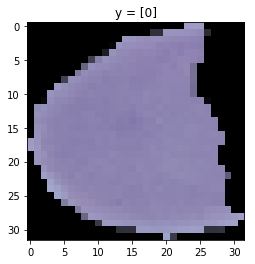

In [10]:
index = 999
predictions = model1.predict(X_test) > 0.5
print(predictions[index])
plt.title("y = %s" % Y_test[index])
plt.imshow(X_test[index])

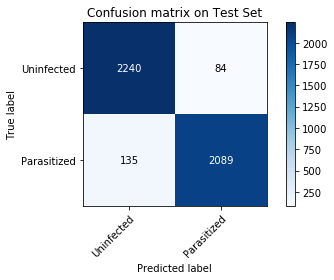

In [11]:
plot_confusion_matrix(Y_test, predictions, classes=["Uninfected","Parasitized"], title='Confusion matrix on Test Set')

### Model 2

In [15]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=8, kernel_size=(7,7), strides=1, padding="same", activation=tf.nn.relu, input_shape=(32,32,3)),
    tf.keras.layers.MaxPool2D(pool_size=(8,8), strides=8, padding="same"),
    
    tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), strides=1, padding="same", activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(pool_size=(4,4), strides=4, padding="same"),
    
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding="same", activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=4, padding="same"),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(7, activation=tf.nn.relu),
    tf.keras.layers.Dense(7, activation=tf.nn.relu),
    tf.keras.layers.Dense(7, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])  

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 8)         1184      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 8)           0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 16)          3216      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 1, 1, 16)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 1, 1, 32)          4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 1, 1, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 32)                0         
__________

In [16]:
optimizer2=tf.train.AdamOptimizer(learning_rate=0.001)
model2.compile(optimizer=optimizer2, loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
model2.fit(X_train, Y_train, epochs=100)

Epoch 1/100
18463/18463 [==============================] - 4s 226us/sample - loss: 0.6223 - acc: 0.6390
Epoch 2/100
18463/18463 [==============================] - 4s 200us/sample - loss: 0.4754 - acc: 0.7777
Epoch 3/100
18463/18463 [==============================] - 4s 206us/sample - loss: 0.4423 - acc: 0.7971
Epoch 4/100
18463/18463 [==============================] - 4s 243us/sample - loss: 0.3939 - acc: 0.8288
Epoch 5/100
18463/18463 [==============================] - 3s 168us/sample - loss: 0.3397 - acc: 0.8648
Epoch 6/100
18463/18463 [==============================] - 3s 172us/sample - loss: 0.2715 - acc: 0.9006
Epoch 7/100
18463/18463 [==============================] - 4s 217us/sample - loss: 0.2359 - acc: 0.9172
Epoch 8/100
18463/18463 [==============================] - 4s 217us/sample - loss: 0.2018 - acc: 0.9315
Epoch 9/100
18463/18463 [==============================] - 4s 209us/sample - loss: 0.1767 - acc: 0.9391
Epoch 10/100
18463/18463 [==============================] - 4s 2

18463/18463 [==============================] - 3s 175us/sample - loss: 0.0471 - acc: 0.9833
Epoch 80/100
18463/18463 [==============================] - 3s 176us/sample - loss: 0.0461 - acc: 0.9850
Epoch 81/100
18463/18463 [==============================] - 3s 184us/sample - loss: 0.0453 - acc: 0.9846
Epoch 82/100
18463/18463 [==============================] - 3s 173us/sample - loss: 0.0512 - acc: 0.9818
Epoch 83/100
18463/18463 [==============================] - 3s 165us/sample - loss: 0.0459 - acc: 0.9841
Epoch 84/100
18463/18463 [==============================] - 3s 163us/sample - loss: 0.0446 - acc: 0.9847
Epoch 85/100
18463/18463 [==============================] - 3s 179us/sample - loss: 0.0478 - acc: 0.9836
Epoch 86/100
18463/18463 [==============================] - 3s 187us/sample - loss: 0.0455 - acc: 0.9842
Epoch 87/100
18463/18463 [==============================] - 4s 198us/sample - loss: 0.0464 - acc: 0.9842
Epoch 88/100
18463/18463 [==============================] - 4s 192us

In [18]:
dev_loss, dev_acc = model2.evaluate(X_dev, Y_dev)

print('Dev set accuracy:', dev_acc)

4547/4547 [==============================] - 0s 108us/sample - loss: 0.2255 - acc: 0.9496
Dev set accuracy: 0.9496371


In [19]:
test_loss, test_acc = model2.evaluate(X_test, Y_test)

print('Test set accuracy:', test_acc)
accuracy.append(test_acc)

4548/4548 [==============================] - 0s 72us/sample - loss: 0.2944 - acc: 0.9439
Test set accuracy: 0.9439314


### Model 3

In [20]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=8, kernel_size=(7,7), strides=1, padding="same", activation=tf.nn.relu, input_shape=(32,32,3)),
    tf.keras.layers.MaxPool2D(pool_size=(8,8), strides=8, padding="same"),
    
    tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), strides=1, padding="same", activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(pool_size=(4,4), strides=4, padding="same"),
    
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding="same", activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=4, padding="same"),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(7, activation=tf.nn.relu),
    tf.keras.layers.Dense(7, activation=tf.nn.relu),
    tf.keras.layers.Dense(7, activation=tf.nn.relu),
    tf.keras.layers.Dense(7, activation=tf.nn.relu),
    tf.keras.layers.Dense(7, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])  

model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 8)         1184      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 4, 8)           0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 4, 4, 16)          3216      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 1, 1, 16)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 1, 1, 32)          4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 1, 1, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 32)                0         
__________

In [21]:
optimizer3 = tf.train.AdamOptimizer(learning_rate=0.001)
model3.compile(optimizer=optimizer3, loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
model3.fit(X_train, Y_train, epochs=100)

Epoch 1/100
18463/18463 [==============================] - 4s 200us/sample - loss: 0.6610 - acc: 0.5800
Epoch 2/100
18463/18463 [==============================] - 3s 179us/sample - loss: 0.5132 - acc: 0.7564
Epoch 3/100
18463/18463 [==============================] - 3s 168us/sample - loss: 0.4503 - acc: 0.7942
Epoch 4/100
18463/18463 [==============================] - 3s 187us/sample - loss: 0.3595 - acc: 0.8468
Epoch 5/100
18463/18463 [==============================] - 3s 174us/sample - loss: 0.2522 - acc: 0.9021
Epoch 6/100
18463/18463 [==============================] - 4s 226us/sample - loss: 0.1773 - acc: 0.9385
Epoch 7/100
18463/18463 [==============================] - 3s 183us/sample - loss: 0.1645 - acc: 0.9454
Epoch 8/100
18463/18463 [==============================] - 3s 184us/sample - loss: 0.1533 - acc: 0.9503
Epoch 9/100
18463/18463 [==============================] - 3s 179us/sample - loss: 0.1504 - acc: 0.9519
Epoch 10/100
18463/18463 [==============================] - 4s 2

18463/18463 [==============================] - 3s 167us/sample - loss: 0.0523 - acc: 0.9830
Epoch 79/100
18463/18463 [==============================] - 3s 182us/sample - loss: 0.0556 - acc: 0.9814
Epoch 80/100
18463/18463 [==============================] - 3s 177us/sample - loss: 0.0501 - acc: 0.9835
Epoch 81/100
18463/18463 [==============================] - 3s 169us/sample - loss: 0.0508 - acc: 0.9833
Epoch 82/100
18463/18463 [==============================] - 3s 177us/sample - loss: 0.0500 - acc: 0.9846
Epoch 83/100
18463/18463 [==============================] - 3s 182us/sample - loss: 0.0505 - acc: 0.9835
Epoch 84/100
18463/18463 [==============================] - 3s 169us/sample - loss: 0.0515 - acc: 0.9835
Epoch 85/100
18463/18463 [==============================] - 3s 170us/sample - loss: 0.0507 - acc: 0.9829
Epoch 86/100
18463/18463 [==============================] - 3s 172us/sample - loss: 0.0516 - acc: 0.9833
Epoch 87/100
18463/18463 [==============================] - 3s 178us

In [23]:
dev_loss, dev_acc = model3.evaluate(X_dev, Y_dev)

print('Dev set accuracy:', dev_acc)

4547/4547 [==============================] - 0s 105us/sample - loss: 0.2510 - acc: 0.9466
Dev set accuracy: 0.9465582


In [24]:
test_loss, test_acc = model3.evaluate(X_test, Y_test)

print('Test set accuracy:', test_acc)
accuracy.append(test_acc)

4548/4548 [==============================] - 0s 79us/sample - loss: 0.2732 - acc: 0.9481
Test set accuracy: 0.94810903


### Model 4

In [25]:
model4 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=8, kernel_size=(7,7), strides=1, padding="same", activation=tf.nn.relu, input_shape=(32,32,3)),
    tf.keras.layers.MaxPool2D(pool_size=(8,8), strides=8, padding="same"),
    
    tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), strides=1, padding="same", activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(pool_size=(4,4), strides=4, padding="same"),
    
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding="same", activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=4, padding="same"),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(8, activation=tf.nn.relu),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])  

model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 32, 32, 8)         1184      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 4, 4, 8)           0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 4, 4, 16)          3216      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 1, 1, 16)          0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 1, 1, 32)          4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 1, 1, 32)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 32)                0         
__________

In [26]:
optimizer4 = tf.train.AdamOptimizer(learning_rate=0.001)
model4.compile(optimizer=optimizer4, 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [27]:
model4.fit(X_train, Y_train, epochs=100)

Epoch 1/100
18463/18463 [==============================] - 3s 188us/sample - loss: 0.6700 - acc: 0.5534
Epoch 2/100
18463/18463 [==============================] - 3s 172us/sample - loss: 0.5132 - acc: 0.7524
Epoch 3/100
18463/18463 [==============================] - 3s 178us/sample - loss: 0.4499 - acc: 0.7876
Epoch 4/100
18463/18463 [==============================] - 3s 160us/sample - loss: 0.3852 - acc: 0.8227
Epoch 5/100
18463/18463 [==============================] - 3s 158us/sample - loss: 0.3300 - acc: 0.8528
Epoch 6/100
18463/18463 [==============================] - 3s 176us/sample - loss: 0.2608 - acc: 0.8908
Epoch 7/100
18463/18463 [==============================] - 3s 177us/sample - loss: 0.1899 - acc: 0.9293
Epoch 8/100
18463/18463 [==============================] - 3s 177us/sample - loss: 0.1699 - acc: 0.9385
Epoch 9/100
18463/18463 [==============================] - 3s 162us/sample - loss: 0.1600 - acc: 0.9443
Epoch 10/100
18463/18463 [==============================] - 3s 1

18463/18463 [==============================] - 3s 155us/sample - loss: 0.0545 - acc: 0.9811
Epoch 80/100
18463/18463 [==============================] - 3s 154us/sample - loss: 0.0475 - acc: 0.9844
Epoch 81/100
18463/18463 [==============================] - 3s 171us/sample - loss: 0.0510 - acc: 0.9826
Epoch 82/100
18463/18463 [==============================] - 3s 177us/sample - loss: 0.0508 - acc: 0.9828
Epoch 83/100
18463/18463 [==============================] - 4s 190us/sample - loss: 0.0478 - acc: 0.9833
Epoch 84/100
18463/18463 [==============================] - 3s 173us/sample - loss: 0.0482 - acc: 0.9845
Epoch 85/100
18463/18463 [==============================] - 3s 182us/sample - loss: 0.0499 - acc: 0.9833
Epoch 86/100
18463/18463 [==============================] - 3s 179us/sample - loss: 0.0527 - acc: 0.9824
Epoch 87/100
18463/18463 [==============================] - 3s 173us/sample - loss: 0.0491 - acc: 0.9836
Epoch 88/100
18463/18463 [==============================] - 3s 174us

In [28]:
dev_loss, dev_acc = model4.evaluate(X_dev, Y_dev)

print('Dev set accuracy:', dev_acc)

4547/4547 [==============================] - 1s 132us/sample - loss: 0.2386 - acc: 0.9488
Dev set accuracy: 0.9487574


In [29]:
test_loss, test_acc = model4.evaluate(X_test, Y_test)

print('Test set accuracy:', test_acc)
accuracy.append(test_acc)

4548/4548 [==============================] - 0s 90us/sample - loss: 0.2576 - acc: 0.9439
Test set accuracy: 0.9439314


### Model 5

In [30]:
model5 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=8, kernel_size=(5,5), strides=1, padding="same", activation=tf.nn.relu, input_shape=(32,32,3)),
    tf.keras.layers.Conv2D(filters=8, kernel_size=(5,5), strides=1, padding="same", activation=tf.nn.relu, input_shape=(32,32,3)),
    tf.keras.layers.MaxPool2D(pool_size=(8,8), strides=8, padding="same"),
    
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=1, padding="same", activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(pool_size=(4,4), strides=4, padding="same"),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(8, activation=tf.nn.relu),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])  

model5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 32, 32, 8)         608       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 8)         1608      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 4, 4, 8)           0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 4, 4, 16)          1168      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 1, 1, 16)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 8)                 136       
__________

In [31]:
model5.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.001), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [32]:
model5.fit(X_train, Y_train, epochs=100)

Epoch 1/100
18463/18463 [==============================] - 4s 201us/sample - loss: 0.5598 - acc: 0.7069
Epoch 2/100
18463/18463 [==============================] - 4s 191us/sample - loss: 0.2164 - acc: 0.9179
Epoch 3/100
18463/18463 [==============================] - 3s 177us/sample - loss: 0.1474 - acc: 0.9501
Epoch 4/100
18463/18463 [==============================] - 4s 215us/sample - loss: 0.1352 - acc: 0.9547
Epoch 5/100
18463/18463 [==============================] - 3s 166us/sample - loss: 0.1298 - acc: 0.9568
Epoch 6/100
18463/18463 [==============================] - 3s 169us/sample - loss: 0.1248 - acc: 0.9579
Epoch 7/100
18463/18463 [==============================] - 3s 167us/sample - loss: 0.1213 - acc: 0.9599
Epoch 8/100
18463/18463 [==============================] - 3s 171us/sample - loss: 0.1177 - acc: 0.9594
Epoch 9/100
18463/18463 [==============================] - 3s 175us/sample - loss: 0.1147 - acc: 0.9602
Epoch 10/100
18463/18463 [==============================] - 3s 1

18463/18463 [==============================] - 3s 169us/sample - loss: 0.0335 - acc: 0.9886
Epoch 80/100
18463/18463 [==============================] - 3s 166us/sample - loss: 0.0324 - acc: 0.9882
Epoch 81/100
18463/18463 [==============================] - 3s 174us/sample - loss: 0.0318 - acc: 0.9887
Epoch 82/100
18463/18463 [==============================] - 3s 179us/sample - loss: 0.0337 - acc: 0.9879
Epoch 83/100
18463/18463 [==============================] - 3s 173us/sample - loss: 0.0301 - acc: 0.9897
Epoch 84/100
18463/18463 [==============================] - 3s 183us/sample - loss: 0.0377 - acc: 0.9856
Epoch 85/100
18463/18463 [==============================] - 3s 175us/sample - loss: 0.0313 - acc: 0.9885
Epoch 86/100
18463/18463 [==============================] - 3s 175us/sample - loss: 0.0301 - acc: 0.9897
Epoch 87/100
18463/18463 [==============================] - 3s 171us/sample - loss: 0.0311 - acc: 0.9888
Epoch 88/100
18463/18463 [==============================] - 3s 173us

In [33]:
dev_loss, dev_acc = model5.evaluate(X_dev, Y_dev)

print('Dev set accuracy:', dev_acc)

4547/4547 [==============================] - 1s 154us/sample - loss: 0.2533 - acc: 0.9461
Dev set accuracy: 0.9461183


In [34]:
test_loss, test_acc = model5.evaluate(X_test, Y_test)

print('Test set accuracy:', test_acc)
accuracy.append(test_acc)

4548/4548 [==============================] - 0s 87us/sample - loss: 0.2661 - acc: 0.9468
Test set accuracy: 0.9467898


In [40]:
for i in range(5):
    print("model "+str(i+1)+" accuracy: " +str(accuracy[i]))

model 1 accuracy: 0.95184696
model 2 accuracy: 0.9439314
model 3 accuracy: 0.94810903
model 4 accuracy: 0.9439314
model 5 accuracy: 0.9467898
